In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_model import ARIMA

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

Using TensorFlow backend.


In [2]:
# load the dataset

dd_df = pd.read_csv("../opioid_deaths/Data/Opioid_Related_Deaths_2012-2018.csv")
dd_df = dd_df.loc[dd_df["Drug_Category"] == 'Synthetic Opioids']

In [3]:
dd_df.index = pd.to_datetime(dd_df['Date'],infer_datetime_format=True)

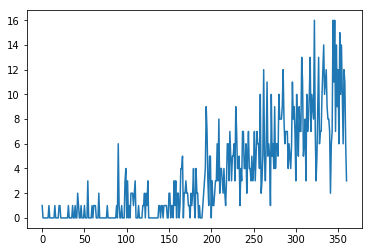

In [4]:
# extract time series
# Group and count deaths by month 
time_series_data = dd_df.groupby(pd.Grouper(freq='W')).count()["ID"]

# plot data
plt.plot(time_series_data.values)
plt.show()

In [5]:
# ============================ LSTM ============================
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

# Function to convert an array of values into a dataset matrix
def create_dataset(data, look_back):
    dataX, dataY = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(data[i + look_back, 0])
    
    return np.array(dataX), np.array(dataY)

In [6]:
# look back 40 data points (months) to make prediction
look_back = 40

# normalize the dataset
# All values should be between 0 and 1. Requirement for neural networks
data = np.reshape(time_series_data.values, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

data_train = data[:300]
data_test = data[(300-look_back+1):]

X_train, y_train = create_dataset(data_train, look_back)
X_test, y_test = create_dataset(data_test, look_back)

C:\Users\MEAGUILA\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [7]:
# reshape input to be [samples, time steps, features]
# Requirement for the model converting from a 2D to a 3D array
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [8]:
# create model and fit the LSTM network
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back))) # 50 LSTM blocks
model.add(Dense(1)) # output
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=2) #epoch - iterations **play batch-size

Epoch 1/50
 - 1s - loss: 0.0151
Epoch 2/50
 - 1s - loss: 0.0127
Epoch 3/50
 - 1s - loss: 0.0121
Epoch 4/50
 - 1s - loss: 0.0113
Epoch 5/50
 - 1s - loss: 0.0117
Epoch 6/50
 - 1s - loss: 0.0117
Epoch 7/50
 - 1s - loss: 0.0116
Epoch 8/50
 - 1s - loss: 0.0112
Epoch 9/50
 - 1s - loss: 0.0112
Epoch 10/50
 - 1s - loss: 0.0109
Epoch 11/50
 - 1s - loss: 0.0112
Epoch 12/50
 - 1s - loss: 0.0112
Epoch 13/50
 - 1s - loss: 0.0108
Epoch 14/50
 - 1s - loss: 0.0107
Epoch 15/50
 - 1s - loss: 0.0109
Epoch 16/50
 - 1s - loss: 0.0107
Epoch 17/50
 - 1s - loss: 0.0107
Epoch 18/50
 - 1s - loss: 0.0101
Epoch 19/50
 - 1s - loss: 0.0101
Epoch 20/50
 - 1s - loss: 0.0106
Epoch 21/50
 - 1s - loss: 0.0103
Epoch 22/50
 - 1s - loss: 0.0100
Epoch 23/50
 - 1s - loss: 0.0104
Epoch 24/50
 - 1s - loss: 0.0103
Epoch 25/50
 - 1s - loss: 0.0103
Epoch 26/50
 - 1s - loss: 0.0098
Epoch 27/50
 - 1s - loss: 0.0094
Epoch 28/50
 - 1s - loss: 0.0097
Epoch 29/50
 - 1s - loss: 0.0100
Epoch 30/50
 - 1s - loss: 0.0098
Epoch 31/50
 - 1s -

In [9]:
# Verify the model
y_pred = []

# forecast the next 50 data points
for val in X_test:
    pred = model.predict(val.reshape(1,1,look_back))
    y_pred = np.append(y_pred,pred)
#     val = np.append(np.delete(val, 0), pred) # update the data batch to be fed in the next iteration

In [10]:
mean_absolute_error(y_pred, y_test)

0.1805313785197371

In [11]:
# make prediction
val = data[-look_back:] # last batch in the training data
predictions = []

# forecast the next 50 data points
for _ in range(50):
    pred = model.predict(val.reshape(1,1,look_back))
    predictions = np.append(predictions,pred)
    val = np.append(np.delete(val, 0), pred) # update the data batch to be fed in the next iteration
    
predictions = predictions.reshape(predictions.shape[0],1)

In [12]:
# reverse forecasted results to its original scale
predictions = scaler.inverse_transform(predictions)

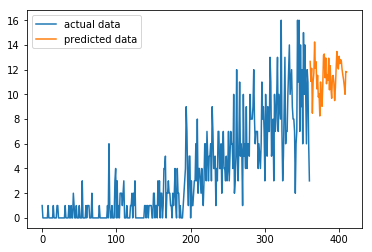

In [13]:
# plot
data_len = len(data)
plt.plot(list(range(data_len)),time_series_data.values,label="actual data")
plt.plot(list(range(data_len,data_len+len(predictions))),predictions,label="predicted data")
plt.legend()
plt.show()

In [14]:
time_series_data.to_csv('predictions_synt.csv')

C:\Users\MEAGUILA\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.
